In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from scipy.stats import gaussian_kde
import warnings
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

warnings.filterwarnings('ignore')

In [2]:

df = pd.read_csv('cs-training.csv')

In [3]:
df.shape

(150000, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,150000.0,75000.500000,43301.414527,1.0,37500.750000,75000.500000,112500.250000,150000.0
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0


a. Dimensiones y Variables
Cantidad de registros: Contamos con 150,000 entradas, lo cual es un volumen manejable, pero siempre debemos optimizar procesos para evitar cuellos de botella.

Columnas: Tenemos 12 columnas, de las cuales dos presentan valores faltantes:

MonthlyIncome: Sólo 120,269 registros completos.

NumberOfDependents: 146,076 registros completos.

Además, se observa la columna Unnamed: 0, que parece ser un índice, por lo que probablemente no aporta información adicional para el análisis.

b. Variables Numéricas y Rangos
SeriousDlqin2yrs (Target):

Distribución: Aproximadamente el 6.7% de los registros tienen valor 1, lo que indica un desbalance de clases, típico en problemas de riesgo crediticio.

RevolvingUtilizationOfUnsecuredLines:

Se detectan valores extremadamente altos (máx: 50,708), lo que sugiere la existencia de outliers. Se debe analizar si estos valores erróneos o casos extremos pueden distorsionar el aprendizaje.

DebtRatio:

Tiene un máximo de 329,664, lo que de nuevo es indicativo de valores atípicos que debemos examinar de cerca.

age:

La edad va de 0 a 109 años, siendo probable que valores como 0 sean errores o casos extremos que deben ser verificados o tratados.

Número de veces en mora:

Las variables “NumberOfTime30-59DaysPastDueNotWorse”, “NumberOfTimes90DaysLate” y “NumberOfTime60-89DaysPastDueNotWorse” presentan máximos elevadísimos (hasta 98 en algunos casos), lo que sugiere outliers o clientes con historiales crediticios muy afectados.

NumberOfDependents:

Aunque se trata de una variable numérica, al tener registros faltantes se debe considerar algún método de imputación o la creación de una categoría “desconocido”.



In [6]:
initial_rows = df.shape[0]
df = df.dropna(subset=['MonthlyIncome'])
print(f"Se eliminaron {initial_rows - df.shape[0]} registros por falta de MonthlyIncome.")

Se eliminaron 29731 registros por falta de MonthlyIncome.


In [7]:
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)
print("Imputación de NumberOfDependents: valores nulos reemplazados por 0.")

Imputación de NumberOfDependents: valores nulos reemplazados por 0.


In [ ]:
def plot_distribution(data, col, apply_log=False):
    plt.figure(figsize=(10, 6))
    
    values = data[col].copy()
    if apply_log:
        offset = 1e-6
        values = np.log(values + offset)
        label = f'Logaritmo de {col}'
    else:
        label = col

    n, bins, patches = plt.hist(values, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    kde = gaussian_kde(values)
    xs = np.linspace(values.min(), values.max(), 200)
    density = kde(xs)
    plt.plot(xs, density, color='red', linewidth=2, label='KDE')
    
    plt.title(f'Distribución de {col} {"(Log Transformado)" if apply_log else ""}')
    plt.xlabel(label)
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.show()


Distribución de RevolvingUtilizationOfUnsecuredLines en escala original:


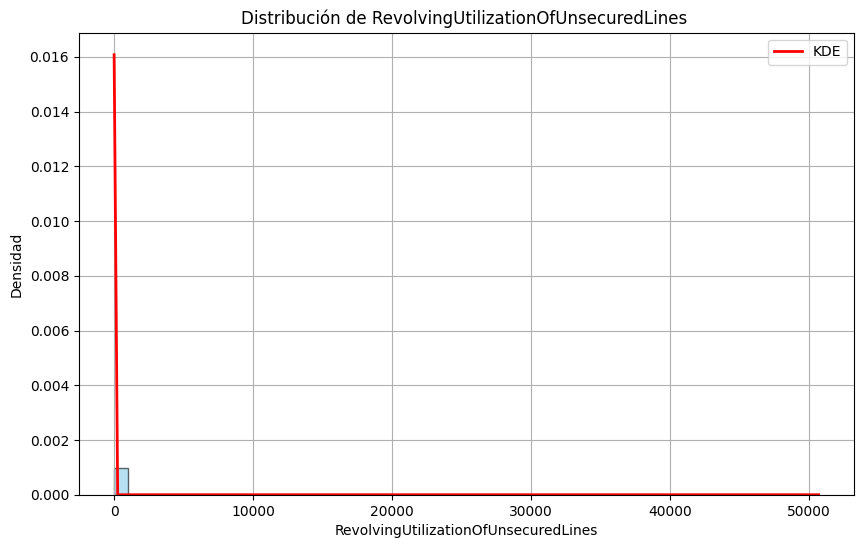

Distribución de RevolvingUtilizationOfUnsecuredLines con transformación logarítmica:


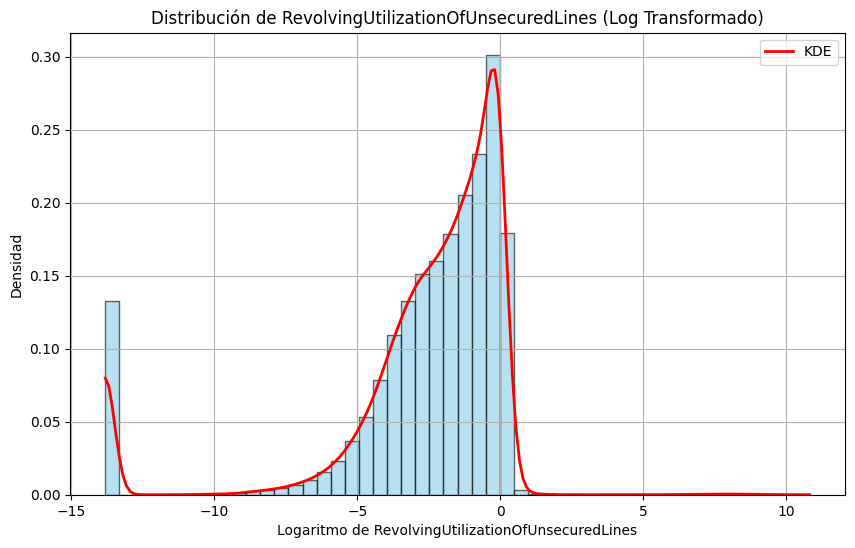

Distribución de DebtRatio en escala original:


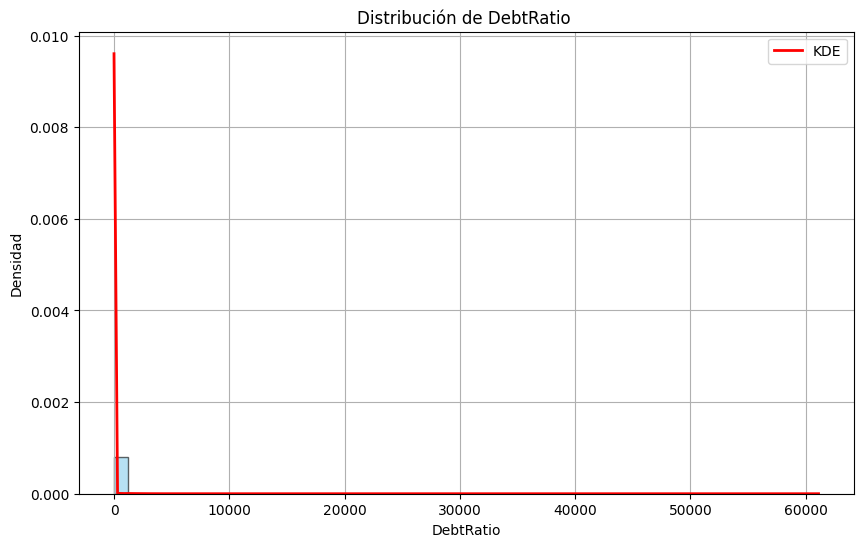

Distribución de DebtRatio con transformación logarítmica:


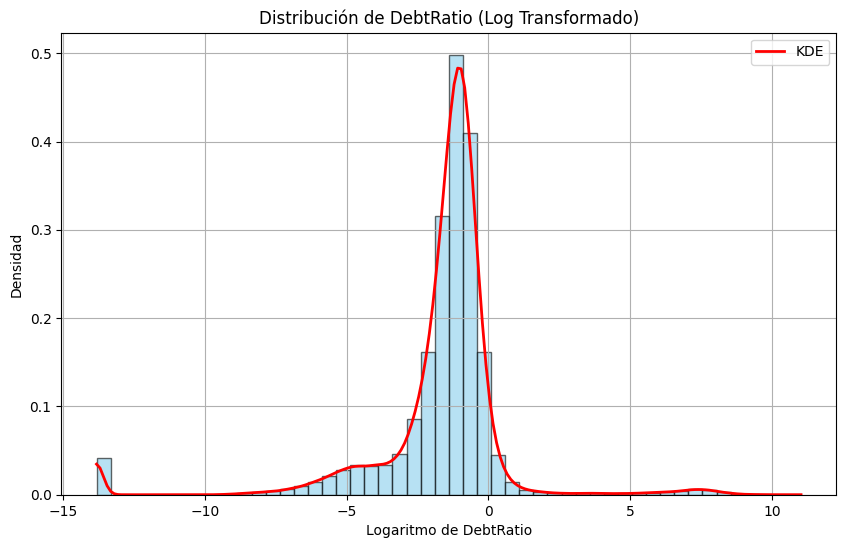

Distribución de MonthlyIncome en escala original:


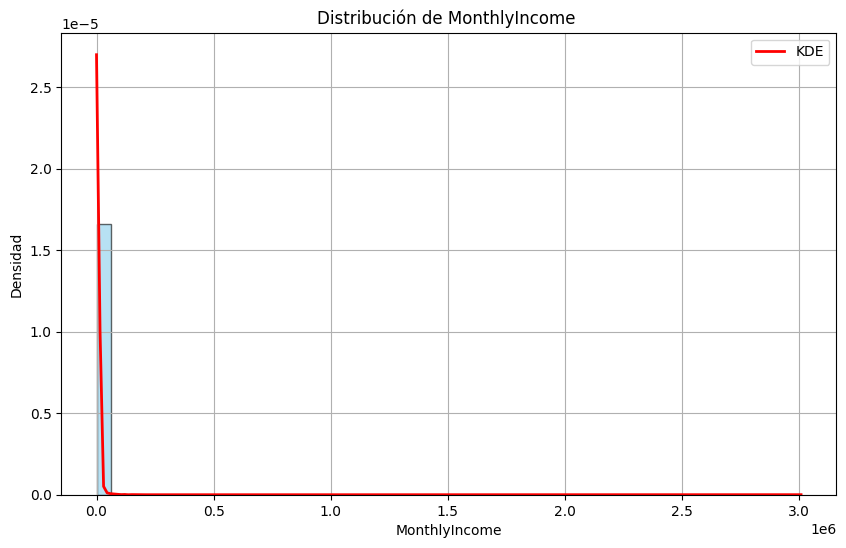

Distribución de MonthlyIncome con transformación logarítmica:


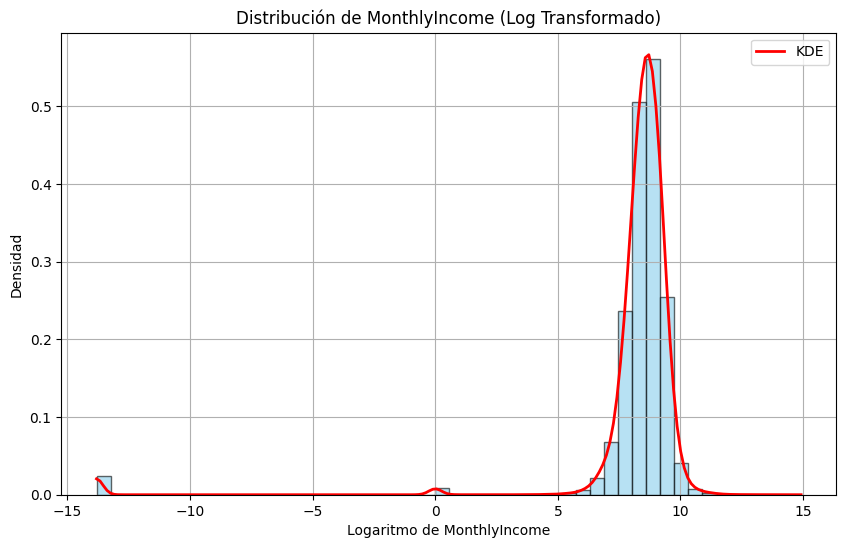

Distribución de age:


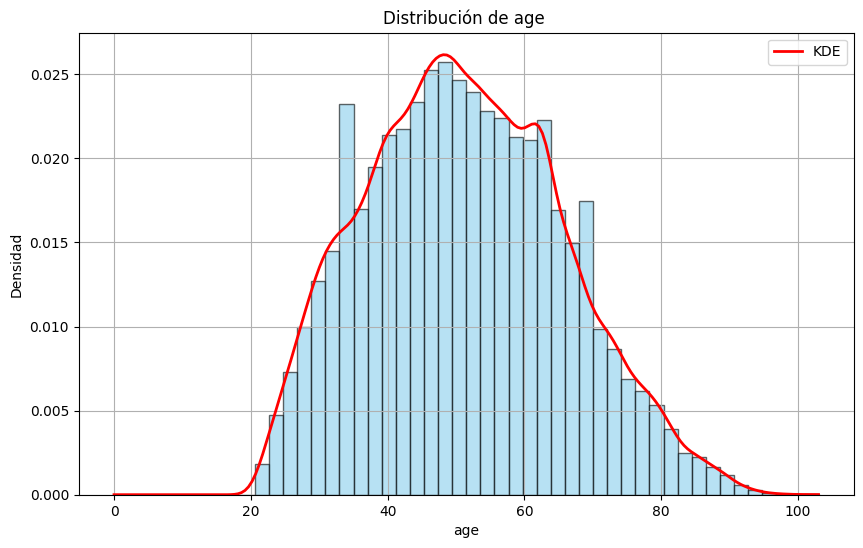

In [ ]:
variables_a_evaluar = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']
for var in variables_a_evaluar:
    print(f"Distribución de {var} en escala original:")
    plot_distribution(df, var, apply_log=False)
    
    print(f"Distribución de {var} con transformación logarítmica:")
    plot_distribution(df, var, apply_log=True)

print("Distribución de age:")
plot_distribution(df, 'age', apply_log=False)

In [ ]:
offset = 1e-6
df['log_MonthlyIncome'] = np.log(df['MonthlyIncome'] + offset)
df['log_DebtRatio'] = np.log(df['DebtRatio'] + offset)

df['log_RevolvingUtilization'] = np.log(df['RevolvingUtilizationOfUnsecuredLines'] + offset)

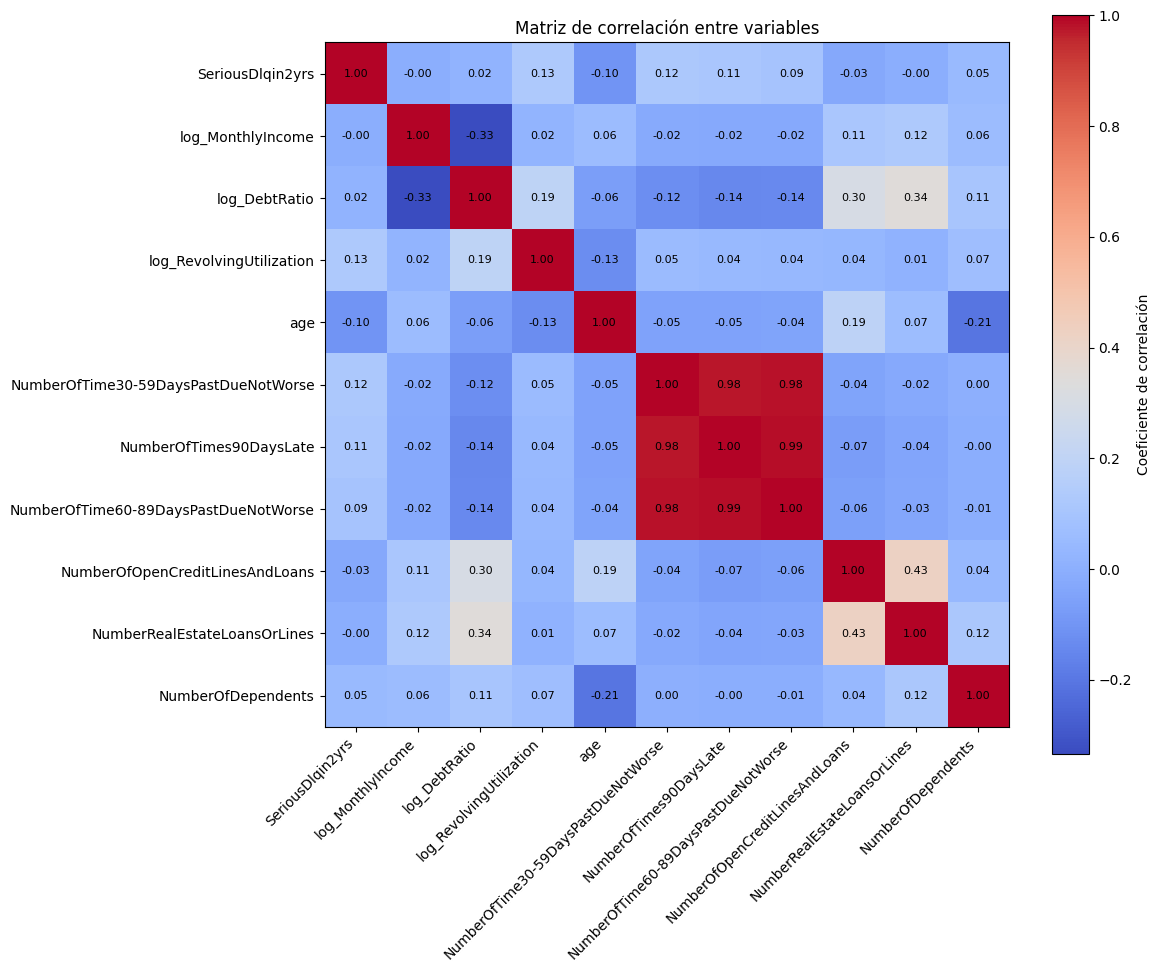

In [ ]:

corr_columns = ['SeriousDlqin2yrs', 'log_MonthlyIncome', 'log_DebtRatio', 
                'log_RevolvingUtilization', 'age', 'NumberOfTime30-59DaysPastDueNotWorse',
                'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 
                'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 
                'NumberOfDependents']

corr_matrix = df[corr_columns].corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Coeficiente de correlación')
plt.xticks(range(len(corr_columns)), corr_columns, rotation=45, ha='right')
plt.yticks(range(len(corr_columns)), corr_columns)
plt.title('Matriz de correlación entre variables')
# Colocamos los coeficientes en cada celda
for i in range(len(corr_columns)):
    for j in range(len(corr_columns)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="black", fontsize=8)
plt.tight_layout()
plt.show()

In [12]:
df['Total_Morosidad'] = (df['NumberOfTime30-59DaysPastDueNotWorse'] +
                         df['NumberOfTimes90DaysLate'] +
                         df['NumberOfTime60-89DaysPastDueNotWorse'])

In [ ]:
#puede capturar la capacidad de pago relativa
df['Income_to_Debt'] = df['log_MonthlyIncome'] / (df['log_DebtRatio'])


In [ ]:
print("Nuevas características creadas:")
print(df[['Total_Morosidad', 'Income_to_Debt']].head())

Nuevas características creadas:
   Total_Morosidad  Income_to_Debt
0                2      -41.555736
1                0       -3.735978
2                2       -3.255298
3                0       -2.438186
4                1       -2.995864


In [15]:
from sklearn.preprocessing import RobustScaler

In [ ]:
features = [
    'log_MonthlyIncome',   
    'log_DebtRatio',           
    'log_RevolvingUtilization', 
    'age',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines',
    'NumberOfDependents',      
    'Total_Morosidad',        
    'Income_to_Debt' 
]

target = 'SeriousDlqin2yrs'

In [17]:
X = df[features]
y = df[target]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'], 
}

In [20]:
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


In [21]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
}

In [ ]:

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, class_weight='balanced')
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}


In [ ]:
ada = AdaBoostClassifier(random_state=42)
ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
}

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [25]:
def run_grid_search(model, param_grid, X_train, y_train, scoring='recall'):
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring,
                        cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print("Mejores hiperparámetros:", grid.best_params_)
    print(f"Mejor {scoring}: {grid.best_score_:.4f}")
    return grid.best_estimator_

In [ ]:

best_lr = run_grid_search(lr, lr_param_grid, X_train_scaled, y_train, scoring='recall')
best_dt = run_grid_search(dt, dt_param_grid, X_train_scaled, y_train, scoring='recall')
best_rf = run_grid_search(rf, rf_param_grid, X_train_scaled, y_train, scoring='recall')
best_xgb = run_grid_search(xgb_clf, xgb_param_grid, X_train_scaled, y_train, scoring='recall')
best_ada = run_grid_search(ada, ada_param_grid, X_train_scaled, y_train, scoring='recall')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámetros: {'C': 0.1, 'penalty': 'l2'}
Mejor recall: 0.6944
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor recall: 0.7876
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores hiperparámetros: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
Mejor recall: 0.7113
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Mejor recall: 0.1967
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mejores hiperparámetros: {'learning_rate': 1, 'n_estimators': 200}
Mejor recall: 0.1941


In [27]:
models_best = {
    "Logistic Regression": best_lr,
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    "AdaBoost": best_ada,
}

In [ ]:
results = {}
for name, model in models_best.items():
    print(f"\nEvaluando modelo: {name}")
    y_pred = model.predict(X_test_scaled)
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    recall = recall_score(y_test, y_pred
    
    results[name] = {"Accuracy": acc, "ROC AUC": auc, "Recall (Default)": recall}
    
    print("Reporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    print("-" * 40)


Evaluando modelo: Logistic Regression
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     22383
           1       0.19      0.68      0.30      1671

    accuracy                           0.78     24054
   macro avg       0.58      0.73      0.58     24054
weighted avg       0.92      0.78      0.83     24054

----------------------------------------

Evaluando modelo: Decision Tree
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.78      0.86     22383
           1       0.20      0.75      0.32      1671

    accuracy                           0.77     24054
   macro avg       0.59      0.77      0.59     24054
weighted avg       0.92      0.77      0.83     24054

----------------------------------------

Evaluando modelo: Random Forest
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97   


MATRICES DE CONFUSIÓN POR MODELO:


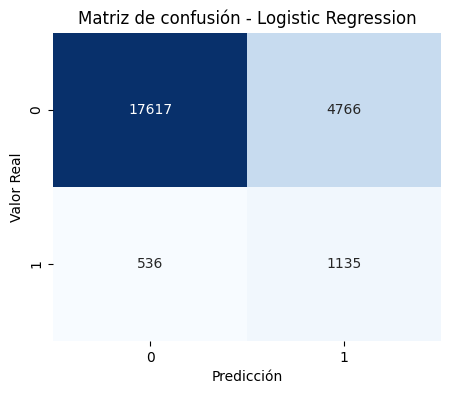

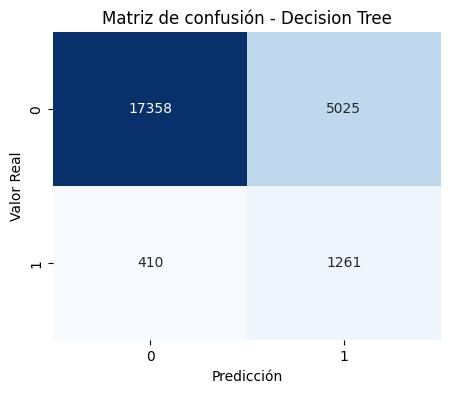

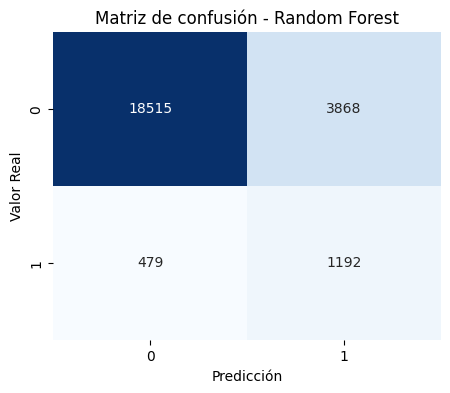

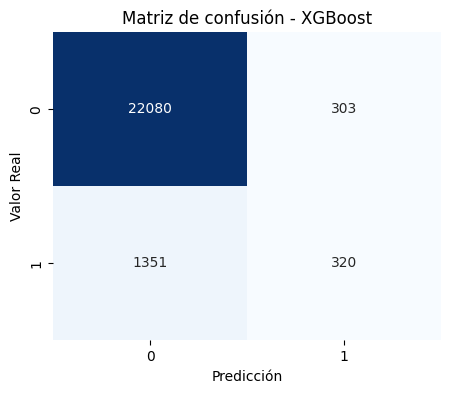

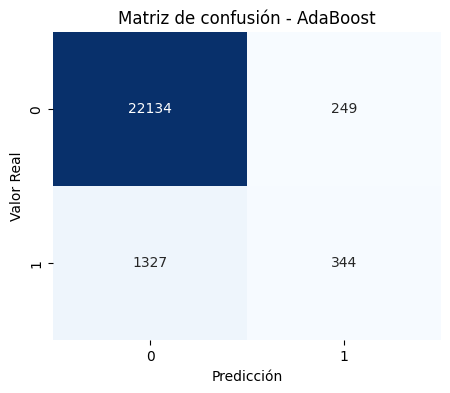

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, recall_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title(title)
    plt.show()

print("\nMATRICES DE CONFUSIÓN POR MODELO:")
for model_name, model in models_best.items():
    y_pred = model.predict(X_test_scaled)
    plot_confusion_matrix(y_test, y_pred, f"Matriz de confusión - {model_name}")


In [ ]:
results_df = pd.DataFrame(results).T
print("\nResumen de métricas en el set de prueba:")
print(results_df)

print("\nComentario:")
print("Dado que el objetivo del negocio es minimizar la cantidad de créditos otorgados a clientes que incumplen,")
print("es crucial maximizar el Recall de la clase de default (es decir, identificar la mayoría de los clientes de alto riesgo).")
print("Una alta sensibilidad en la detección del incumplimiento ayudará a reducir el número de falsos negativos (casos donde")
print("se aprueba crédito a alguien que incumple). En este contexto, además del Accuracy y el ROC AUC, priorizamos el Recall.")


Resumen de métricas en el set de prueba:
                     Accuracy   ROC AUC  Recall (Default)
Logistic Regression  0.779579  0.802537          0.679234
Decision Tree        0.774050  0.839393          0.754638
Random Forest        0.819282  0.844294          0.713345
XGBoost              0.931238  0.832918          0.191502
AdaBoost             0.934481  0.846224          0.205865

Comentario:
Dado que el objetivo del negocio es minimizar la cantidad de créditos otorgados a clientes que incumplen,
es crucial maximizar el Recall de la clase de default (es decir, identificar la mayoría de los clientes de alto riesgo).
Una alta sensibilidad en la detección del incumplimiento ayudará a reducir el número de falsos negativos (casos donde
se aprueba crédito a alguien que incumple). En este contexto, además del Accuracy y el ROC AUC, priorizamos el Recall.


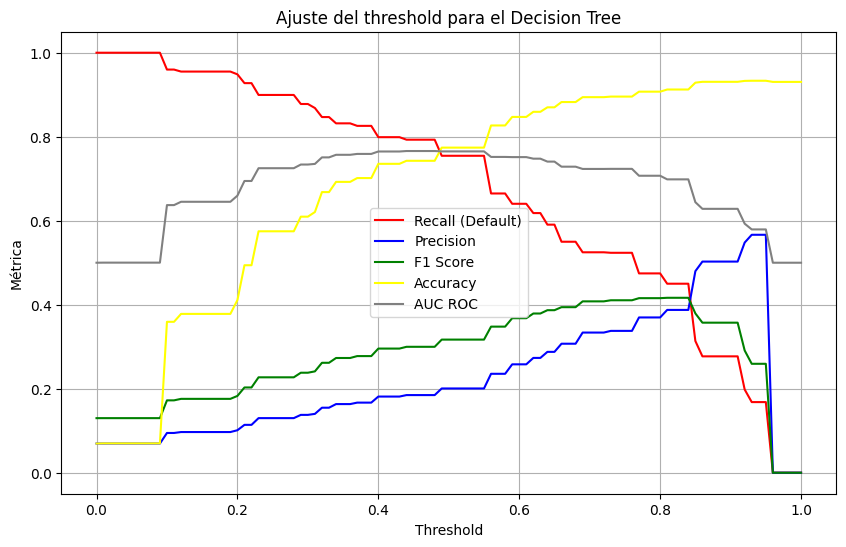

In [ ]:

y_prob = best_dt.predict_proba(X_test_scaled)[:, 1]

thresholds = np.linspace(0.0, 1.0, 101)
recalls = []
precisions = []
f1_scores = []
accs = []
aucs = []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh)
    acc = accuracy_score(y_test, y_pred_thresh)
    auc = roc_auc_score(y_test, y_pred_thresh)
    
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)
    accs.append(acc)
    aucs.append(auc)

plt.figure(figsize=(10,6))
plt.plot(thresholds, recalls, label='Recall (Default)', color='red')
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, f1_scores, label='F1 Score', color='green')
plt.plot(thresholds, accs, label='Accuracy', color='yellow')
plt.plot(thresholds, aucs, label='AUC ROC', color='gray')
plt.xlabel('Threshold')
plt.ylabel('Métrica')
plt.title('Ajuste del threshold para el Decision Tree')
plt.legend()
plt.grid(True)
plt.show()

1. Descripción de cómo construir la variable objetivo (target) si no estuviera disponible
En un escenario en el que la variable SeriousDlqin2yrs no estuviera disponible, se requeriría:

Definir la lógica de negocio para default o incumplimiento:

Por ejemplo, considerar a un cliente en default cuando exceda 90 días de impago en cualquiera de sus obligaciones crediticias.

Para ello, se tomaría información histórica de pagos y se etiquetaría cada período/cliente con 1 si se cumplieran las condiciones de mora (≥90 días de retraso), y con 0 si no.

Integrar datos de comportamiento de pago:

Obtener el registro histórico de facturas, fechas de vencimiento y fechas reales de pago.

Calcular automáticamente un indicador de días de atraso y, con base en el punto de corte (90 días), generar la etiqueta (1 = default, 0 = no default).

Verificación y limpieza:

Validar que las reglas definidas reflejen consistentemente la realidad de negocio. Por ejemplo, podría haber ciertos tipos de atraso que no se consideren default si hubo restructuración.

Alinear criterios con el departamento financiero o el área de riesgo para asegurar que la definición de default sea confiable.

Este proceso se repetiría para cada cliente o préstamo para construir un conjunto de datos rotulado que sirva como base para entrenar modelos de predicción de default.



2. Métricas relevantes para elegir el mejor modelo y prioridades
Existen varias métricas de clasificación importantes en problemas de riesgo crediticio:

Recall (Sensibilidad) de la clase default:

Mide la proporción de clientes incumplidos (default) que el modelo identifica correctamente.

Es crucial cuando el costo de no detectar un default es alto (pérdidas financieras).

Se prioriza en escenarios donde el negocio prefiere “sobreprevenir” (aceptar falsos positivos) que arriesgarse a perder dinero al no identificar a un posible defaulter.

Precision de la clase default:

Indica qué proporción de clientes clasificados como default realmente incumplen.

Útil cuando el costo de etiquetar erróneamente (falsos positivos) es alto.

ROC AUC:

Refleja la capacidad general del modelo para discriminar entre defaulters y no defaulters.

Es una métrica muy usada en problemas de scoring, pues evalúa la efectividad del modelo en múltiples puntos de corte.

F1 Score (para la clase default):

Es la media armónica de precision y recall. Se utiliza cuando buscamos un equilibrio entre ambas.

Accuracy:

Aunque se usa con frecuencia, en un problema de default con clases desbalanceadas puede ser engañosa, pues acertar con la clase mayoritaria (no default) genera altas exactitudes sin necesariamente detectar la clase minoritaria.

Por qué priorizar recall:
En la mayoría de escenarios de crédito, clasificar a alguien que no paga como un buen pagador (falso negativo) puede acarrear pérdidas mayores que rechazar a alguien que sí paga (falso positivo). Por tanto, es preferible maximizar la detección de clientes de alto riesgo (maximizar recall) aunque esto implique sacrificar algo de precision.

3. Efecto del cutoff o threshold en la predicción de probabilidad de default
El threshold (normalmente 0.5 por defecto) define cuándo clasificamos a un cliente como incumplidor:

Si bajas el threshold (por debajo de 0.5):

Aumenta la cantidad de clientes clasificados como “default”.

Tiendes a tener mayor recall (atrapas más defaulters) pero podría aumentar el número de falsos positivos.

Si subes el threshold (por encima de 0.5):

Reduces la cantidad de clientes clasificados como “default”.

Aumenta la precision para la clase default (menos falsos positivos), pero disminuye el recall (más falsos negativos).

En un contexto de riesgo crediticio, se elige el threshold analizando el costo de un falso negativo (pérdida por prestar a quien no paga) versus el costo de un falso positivo (dejar de prestar a un cliente que sí habría pagado). Por eso, se evalúan curvas de recall-precision o se hace un análisis de costo-beneficio para definir el punto óptimo

4. Variables adicionales en el contexto de AB InBev
Dado el foco en bares, restaurantes y tiendas de conveniencia, podrían considerarse variables que capturen la realidad específica de estos negocios:

Geolocalización y segmentación de mercado:

Ubicación del establecimiento (zona turística, zona residencial, cercanía a competencia).

Dinámica de consumo local (por ejemplo, festividades, eventos deportivos).

Información transaccional con AB InBev:

Historial de compra de productos (volumen, frecuencia, estacionalidad).

Puntualidad en pagos de facturas previas y tendencia de consumo.

Tipo de local (bar nocturno, restaurante familiar, tienda de conveniencia 24h, etc.) y su ticket promedio.

Indicadores macroeconómicos o del sector:

Tasas de desempleo o variaciones en ingresos de la zona.

Cambios en políticas o regulaciones que afecten el consumo de bebidas alcohólicas o el horario de operación.

Modelado de la cartera del cliente:

Si el cliente maneja varias líneas de negocio o múltiples locales.

Presencia de otros proveedores, deudas simultáneas, márgenes de ganancia, etc.

Estas variables podrían enriquecer el modelo, ya que reflejan mejor el comportamiento crediticio y la capacidad de pago de establecimientos del sector de bebidas y retail.


Calibrando el modelo con mejor Recall: Decision Tree (Isotonic Calibration)

Métricas del modelo calibrado (Isotonic):
Accuracy: 0.9333
ROC AUC : 0.8407
Recall (Default): 0.1682
Reporte de Clasificación (modelo calibrado):
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     22383
           1       0.57      0.17      0.26      1671

    accuracy                           0.93     24054
   macro avg       0.75      0.58      0.61     24054
weighted avg       0.91      0.93      0.92     24054



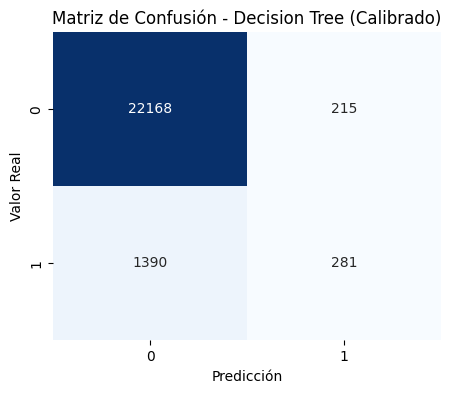


Evaluando variaciones de threshold en el modelo calibrado:

---------------- Threshold = 0.10 ----------------
Accuracy : 0.8451
Recall   : 0.6439
Precision: 0.2557
F1 Score : 0.3660
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     22383
           1       0.26      0.64      0.37      1671

    accuracy                           0.85     24054
   macro avg       0.61      0.75      0.64     24054
weighted avg       0.92      0.85      0.87     24054



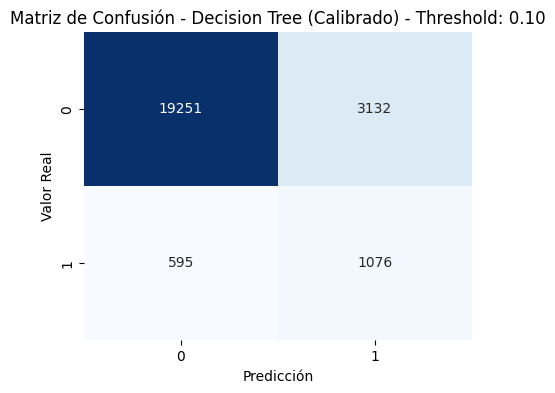


---------------- Threshold = 0.20 ----------------
Accuracy : 0.9020
Recall   : 0.5051
Precision: 0.3554
F1 Score : 0.4172
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     22383
           1       0.36      0.51      0.42      1671

    accuracy                           0.90     24054
   macro avg       0.66      0.72      0.68     24054
weighted avg       0.92      0.90      0.91     24054



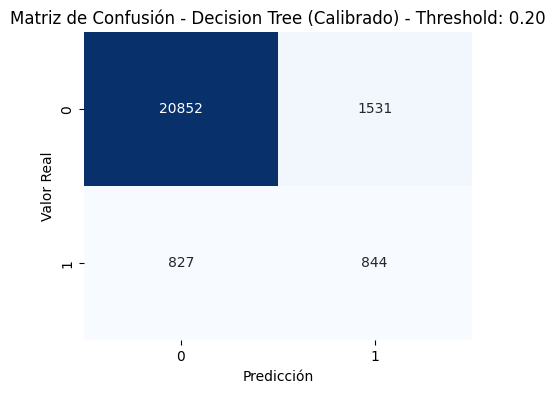


---------------- Threshold = 0.30 ----------------
Accuracy : 0.9233
Recall   : 0.3782
Precision: 0.4398
F1 Score : 0.4067
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     22383
           1       0.44      0.38      0.41      1671

    accuracy                           0.92     24054
   macro avg       0.70      0.67      0.68     24054
weighted avg       0.92      0.92      0.92     24054



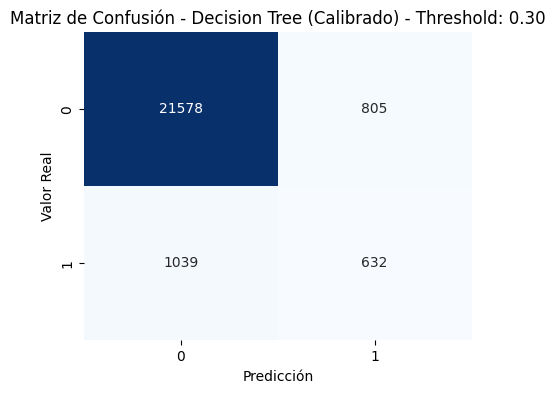


---------------- Threshold = 0.40 ----------------
Accuracy : 0.9331
Recall   : 0.2280
Precision: 0.5443
F1 Score : 0.3214
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     22383
           1       0.54      0.23      0.32      1671

    accuracy                           0.93     24054
   macro avg       0.74      0.61      0.64     24054
weighted avg       0.92      0.93      0.92     24054



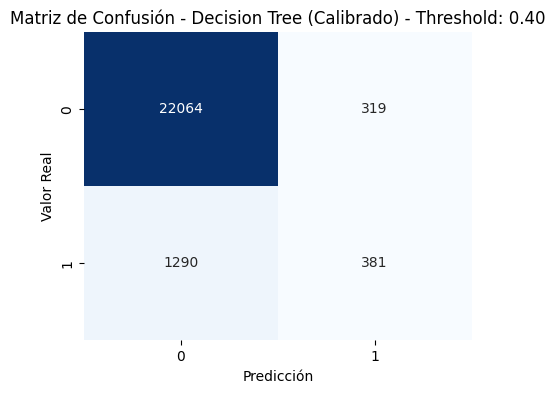


---------------- Threshold = 0.50 ----------------
Accuracy : 0.9333
Recall   : 0.1682
Precision: 0.5665
F1 Score : 0.2593
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     22383
           1       0.57      0.17      0.26      1671

    accuracy                           0.93     24054
   macro avg       0.75      0.58      0.61     24054
weighted avg       0.91      0.93      0.92     24054



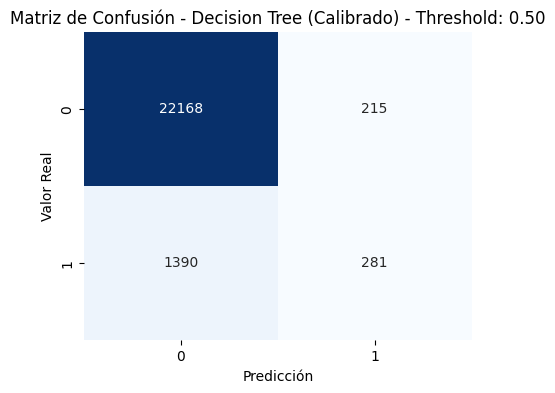


---------------- Threshold = 0.60 ----------------
Accuracy : 0.9334
Recall   : 0.1065
Precision: 0.6224
F1 Score : 0.1819
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     22383
           1       0.62      0.11      0.18      1671

    accuracy                           0.93     24054
   macro avg       0.78      0.55      0.57     24054
weighted avg       0.92      0.93      0.91     24054



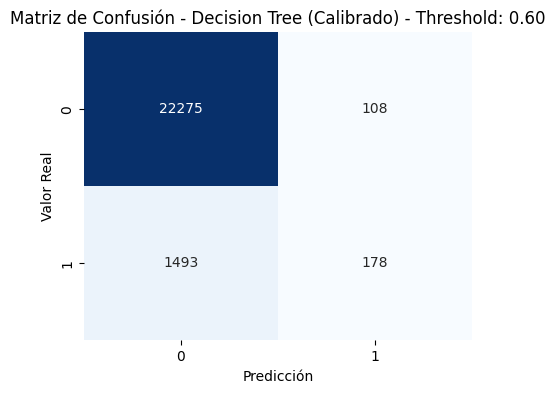


---------------- Threshold = 0.70 ----------------
Accuracy : 0.9305
Recall   : 0.0000
Precision: 0.0000
F1 Score : 0.0000
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     22383
           1       0.00      0.00      0.00      1671

    accuracy                           0.93     24054
   macro avg       0.47      0.50      0.48     24054
weighted avg       0.87      0.93      0.90     24054



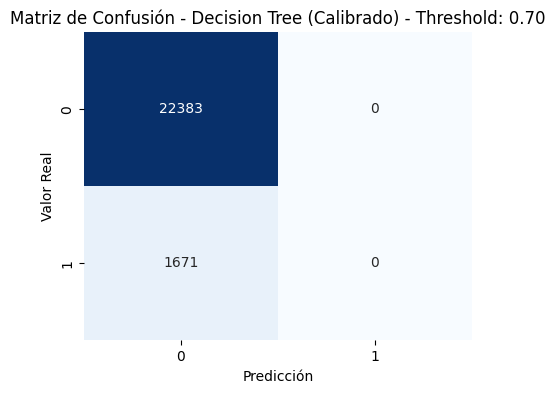


---------------- Threshold = 0.80 ----------------
Accuracy : 0.9305
Recall   : 0.0000
Precision: 0.0000
F1 Score : 0.0000
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     22383
           1       0.00      0.00      0.00      1671

    accuracy                           0.93     24054
   macro avg       0.47      0.50      0.48     24054
weighted avg       0.87      0.93      0.90     24054



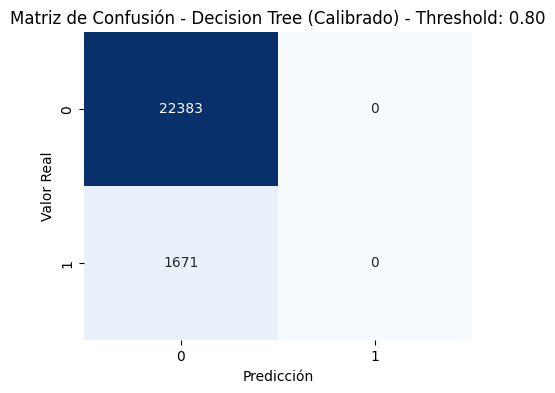


---------------- Threshold = 0.90 ----------------
Accuracy : 0.9305
Recall   : 0.0000
Precision: 0.0000
F1 Score : 0.0000
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     22383
           1       0.00      0.00      0.00      1671

    accuracy                           0.93     24054
   macro avg       0.47      0.50      0.48     24054
weighted avg       0.87      0.93      0.90     24054



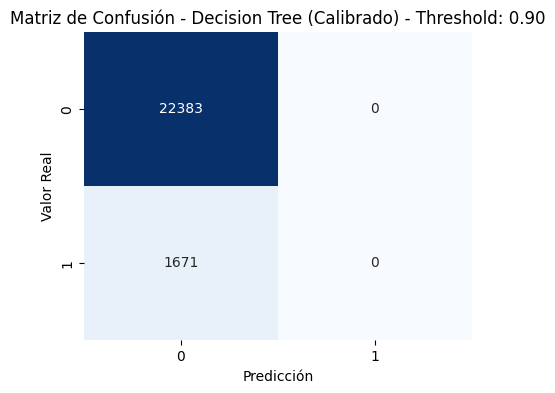


Comentario:
La calibración isotónica mejora la calidad de las probabilidades pronosticadas,
lo que nos permite ajustar el threshold de clasificación para maximizar el Recall (sensibilidad) de la clase default.
Al variar el threshold, observamos el trade-off entre Recall y Precision, y podemos seleccionar el punto óptimo
según la tolerancia al riesgo y los costos asociados en la toma de decisiones en el negocio.


In [ ]:

best_model_name = "Decision Tree"  
best_model = models_best[best_model_name]

print(f"\nCalibrando el modelo con mejor Recall: {best_model_name} (Isotonic Calibration)\n")

calibrated_model = CalibratedClassifierCV(best_model, method='sigmoid')
calibrated_model.fit(X_train_scaled, y_train)

y_pred_cal = calibrated_model.predict(X_test_scaled)
y_prob_cal = calibrated_model.predict_proba(X_test_scaled)[:, 1]

acc_cal = accuracy_score(y_test, y_pred_cal)
auc_cal = roc_auc_score(y_test, y_prob_cal)
recall_cal = recall_score(y_test, y_pred_cal)

print("Métricas del modelo calibrado (Isotonic):")
print(f"Accuracy: {acc_cal:.4f}")
print(f"ROC AUC : {auc_cal:.4f}")
print(f"Recall (Default): {recall_cal:.4f}")
print("Reporte de Clasificación (modelo calibrado):")
print(classification_report(y_test, y_pred_cal))

plot_confusion_matrix(y_test, y_pred_cal, f"Matriz de Confusión - {best_model_name} (Calibrado)")


thresholds = np.linspace(0.1, 0.9, 9)
print("\nEvaluando variaciones de threshold en el modelo calibrado:")

for thresh in thresholds:
    print(f"\n---------------- Threshold = {thresh:.2f} ----------------")
    y_pred_thresh = (y_prob_cal >= thresh).astype(int)
    
    acc = accuracy_score(y_test, y_pred_thresh)
    recall_val = recall_score(y_test, y_pred_thresh)
    precision_val = precision_score(y_test, y_pred_thresh, zero_division=0)
    f1_val = f1_score(y_test, y_pred_thresh)
    
    print(f"Accuracy : {acc:.4f}")
    print(f"Recall   : {recall_val:.4f}")
    print(f"Precision: {precision_val:.4f}")
    print(f"F1 Score : {f1_val:.4f}")
    print("Reporte de Clasificación:")
    print(classification_report(y_test, y_pred_thresh))
    
    # Mostrar la matriz de confusión para el threshold actual
    plot_confusion_matrix(y_test, y_pred_thresh, 
                          f"Matriz de Confusión - {best_model_name} (Calibrado) - Threshold: {thresh:.2f}")

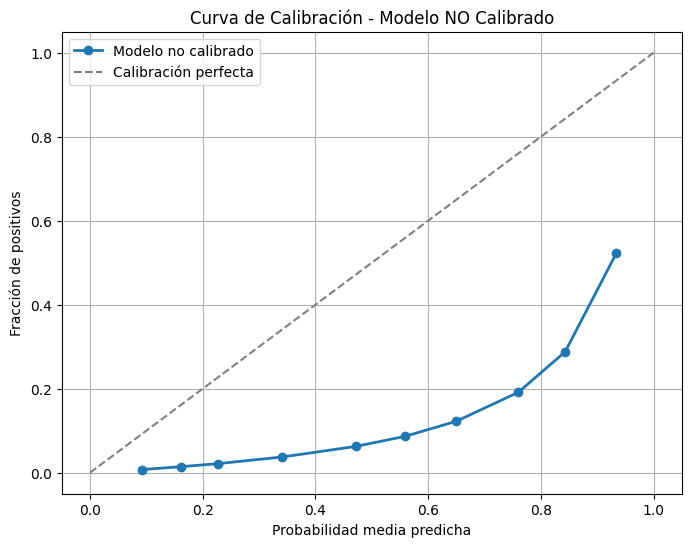

In [ ]:

best_model_uncalibrated = models_best[best_model_name]

prob_true_no_cal, prob_pred_no_cal = calibration_curve(
    y_train,
    best_model_uncalibrated.predict_proba(X_train_scaled)[:, 1],
    n_bins=10
)

plt.figure(figsize=(8,6))
plt.plot(prob_pred_no_cal, prob_true_no_cal, marker='o', linewidth=2, label='Modelo no calibrado')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibración perfecta')
plt.xlabel("Probabilidad media predicha")
plt.ylabel("Fracción de positivos")
plt.title("Curva de Calibración - Modelo NO Calibrado")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

df_test = pd.read_csv('cs-test.csv')

if 'Unnamed: 0' in df_test.columns:
    df_test.drop('Unnamed: 0', axis=1, inplace=True)

df_test = df_test.dropna(subset=['MonthlyIncome'])

df_test['NumberOfDependents'] = df_test['NumberOfDependents'].fillna(0)

offset = 1e-6
df_test['log_MonthlyIncome'] = np.log(df_test['MonthlyIncome'] + offset)
df_test['log_DebtRatio'] = np.log(df_test['DebtRatio'] + offset)
df_test['log_RevolvingUtilization'] = np.log(df_test['RevolvingUtilizationOfUnsecuredLines'] + offset)

df_test['Total_Morosidad'] = (df_test['NumberOfTime30-59DaysPastDueNotWorse'] +
                              df_test['NumberOfTimes90DaysLate'] +
                              df_test['NumberOfTime60-89DaysPastDueNotWorse'])

df_test['Income_to_Debt'] = df_test['log_MonthlyIncome'] / (df_test['log_DebtRatio'] + offset)

features = [
    'log_MonthlyIncome',
    'log_DebtRatio',
    'log_RevolvingUtilization',
    'age',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines',
    'NumberOfDependents',
    'Total_Morosidad',
    'Income_to_Debt'
]
X_test_final = df_test[features]

X_test_final_scaled = scaler.transform(X_test_final)

y_prob_no_cal = best_model_uncalibrated.predict_proba(X_test_final_scaled)[:, 1]

if 'ID' in df_test.columns:
    result_df_no_cal = df_test[['ID']].copy()
else:
    result_df_no_cal = pd.DataFrame({'ID': df_test.index})

result_df_no_cal['RiskProbability'] = y_prob_no_cal

result_df_no_cal.to_csv('predictions_cs_test_no_calibrado.csv', index=False)
print("Predicciones no calibradas guardadas en 'predictions_cs_test_no_calibrado.csv'")


Predicciones no calibradas guardadas en 'predictions_cs_test_no_calibrado.csv'


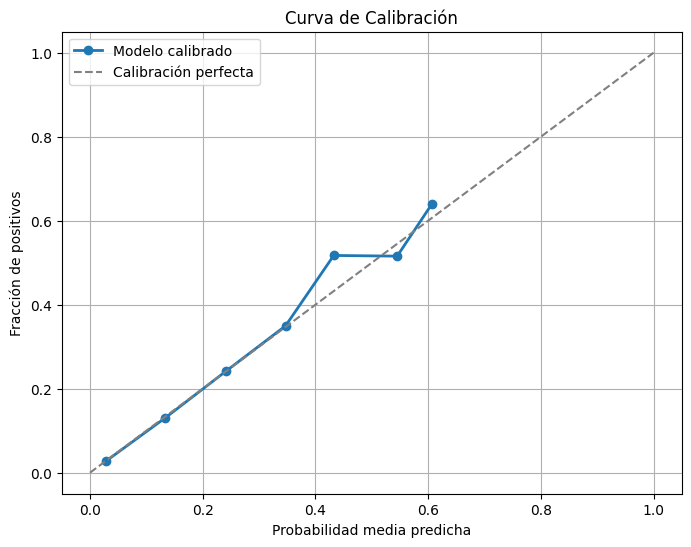

In [ ]:

prob_true, prob_pred = calibration_curve(y_train, calibrated_model.predict_proba(X_train_scaled)[:,1], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Modelo calibrado')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Calibración perfecta')
plt.xlabel("Probabilidad media predicha")
plt.ylabel("Fracción de positivos")
plt.title("Curva de Calibración")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:


df_test = pd.read_csv('cs-test.csv')


if 'Unnamed: 0' in df_test.columns:
    df_test.drop('Unnamed: 0', axis=1, inplace=True)

df_test = df_test.dropna(subset=['MonthlyIncome'])

df_test['NumberOfDependents'] = df_test['NumberOfDependents'].fillna(0)

offset = 1e-6

df_test['log_MonthlyIncome'] = np.log(df_test['MonthlyIncome'] + offset)
df_test['log_DebtRatio'] = np.log(df_test['DebtRatio'] + offset)
df_test['log_RevolvingUtilization'] = np.log(df_test['RevolvingUtilizationOfUnsecuredLines'] + offset)

df_test['Total_Morosidad'] = (df_test['NumberOfTime30-59DaysPastDueNotWorse'] +
                              df_test['NumberOfTimes90DaysLate'] +
                              df_test['NumberOfTime60-89DaysPastDueNotWorse'])

df_test['Income_to_Debt'] = df_test['log_MonthlyIncome'] / (df_test['log_DebtRatio'] + offset)

features = [
    'log_MonthlyIncome',
    'log_DebtRatio',
    'log_RevolvingUtilization',
    'age',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines',
    'NumberOfDependents',
    'Total_Morosidad',
    'Income_to_Debt'
]

X_test_final = df_test[features]

X_test_final_scaled = scaler.transform(X_test_final)


y_test_prob = calibrated_model.predict_proba(X_test_final_scaled)[:, 1]

if 'ID' in df_test.columns:
    result_df = df_test[['ID']].copy()
else:
    result_df = pd.DataFrame({'ID': df_test.index})

result_df['RiskProbability'] = y_test_prob


result_df.to_csv('predictions_cs_test.csv', index=False)
print("Predicciones guardadas en 'predictions_cs_test.csv'")


Predicciones guardadas en 'predictions_cs_test.csv'


k=2: Silhouette=0.9999, Calinski-Harabasz=830494.56, Davies-Bouldin=0.0001
k=3: Silhouette=1.0000, Calinski-Harabasz=110014684.96, Davies-Bouldin=0.0407
k=4: Silhouette=1.0000, Calinski-Harabasz=217426997.33, Davies-Bouldin=0.3064
k=5: Silhouette=1.0000, Calinski-Harabasz=313240560.66, Davies-Bouldin=0.2749
k=6: Silhouette=1.0000, Calinski-Harabasz=603233930.00, Davies-Bouldin=0.1890
k=7: Silhouette=0.9993, Calinski-Harabasz=961273494.89, Davies-Bouldin=0.2385
k=8: Silhouette=0.9992, Calinski-Harabasz=1112451379.34, Davies-Bouldin=0.2025
k=9: Silhouette=0.9992, Calinski-Harabasz=1394707686.66, Davies-Bouldin=0.1622
k=10: Silhouette=0.9992, Calinski-Harabasz=1717578830.50, Davies-Bouldin=0.0948


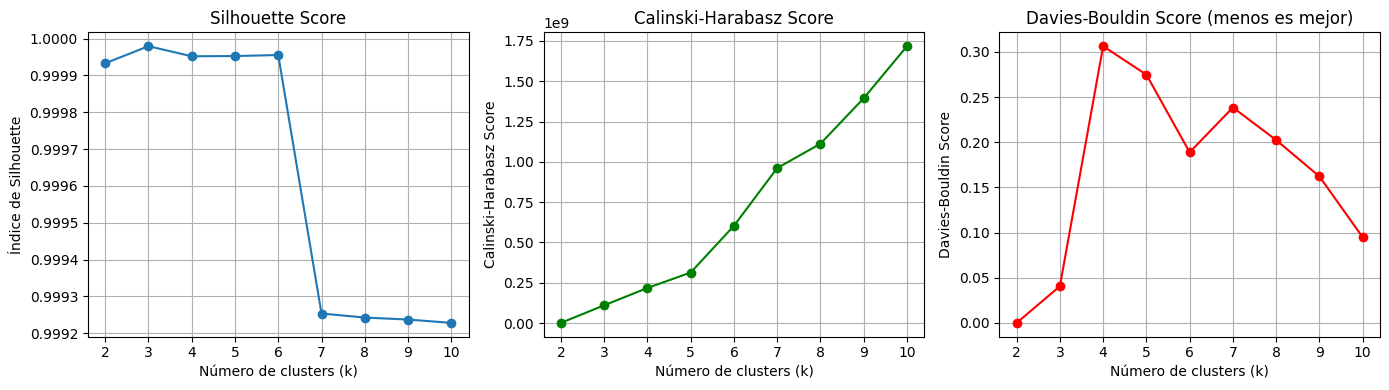

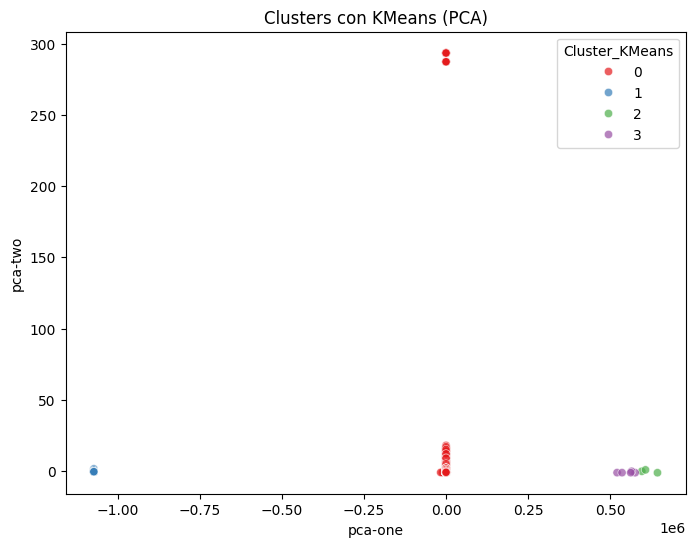

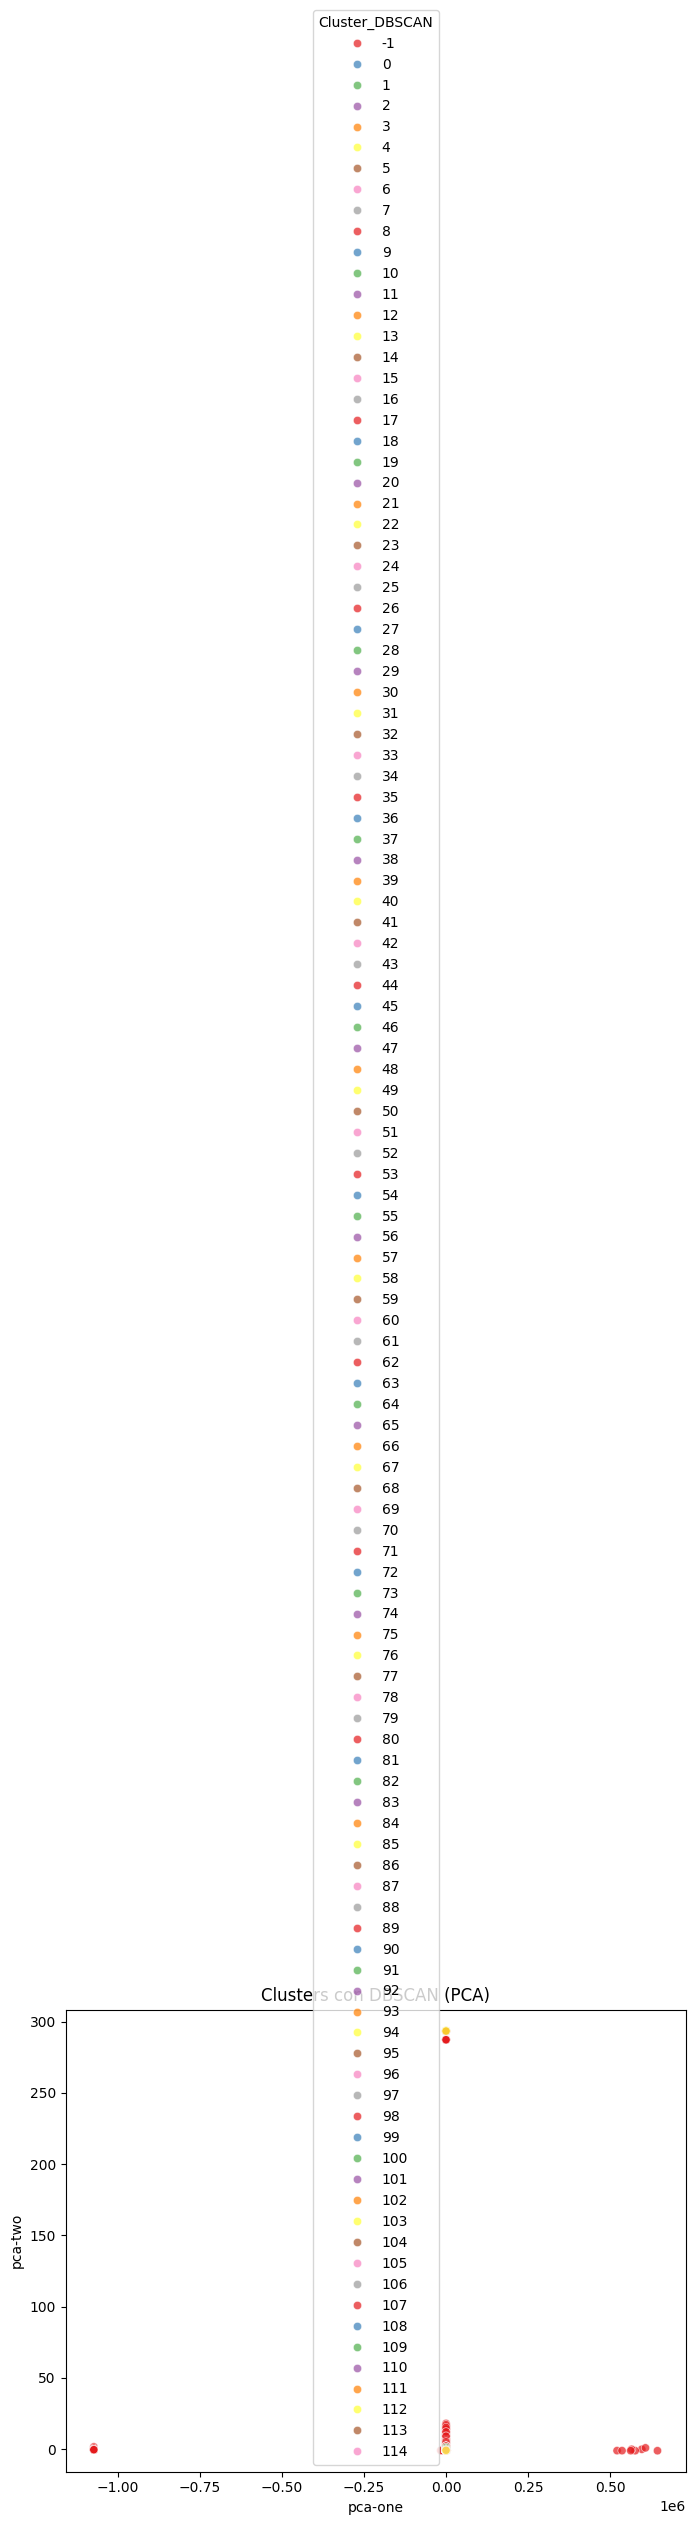

Segmentación de clientes guardada en 'client_segmentation.csv'


In [ ]:
df = pd.read_csv('cs-training.csv')
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

df = df.dropna(subset=['MonthlyIncome'])
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)


offset = 1e-6
df['log_MonthlyIncome'] = np.log(df['MonthlyIncome'] + offset)
df['log_DebtRatio'] = np.log(df['DebtRatio'] + offset)
df['log_RevolvingUtilization'] = np.log(df['RevolvingUtilizationOfUnsecuredLines'] + offset)
df['Total_Morosidad'] = (df['NumberOfTime30-59DaysPastDueNotWorse'] +
                         df['NumberOfTimes90DaysLate'] +
                         df['NumberOfTime60-89DaysPastDueNotWorse'])
df['Income_to_Debt'] = df['log_MonthlyIncome'] / (df['log_DebtRatio'] + offset)


features = [
    'log_MonthlyIncome',
    'log_DebtRatio',
    'log_RevolvingUtilization',
    'age',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines',
    'NumberOfDependents',
    'Total_Morosidad',
    'Income_to_Debt'
]
X = df[features].copy()

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

siluetas, calinski, davies = [], [], []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    clusters = kmeans.fit_predict(X_scaled)
    sil_score = silhouette_score(X_scaled, clusters)
    calinski_score = calinski_harabasz_score(X_scaled, clusters)
    davies_score = davies_bouldin_score(X_scaled, clusters)
    siluetas.append(sil_score)
    calinski.append(calinski_score)
    davies.append(davies_score)
    print(f"k={k}: Silhouette={sil_score:.4f}, Calinski-Harabasz={calinski_score:.2f}, Davies-Bouldin={davies_score:.4f}")


plt.figure(figsize=(14, 4))
plt.subplot(1,3,1)
plt.plot(k_values, siluetas, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Índice de Silhouette")
plt.title("Silhouette Score")
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(k_values, calinski, marker='o', color='green')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.title("Calinski-Harabasz Score")
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(k_values, davies, marker='o', color='red')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Davies-Bouldin Score")
plt.title("Davies-Bouldin Score (menos es mejor)")
plt.grid(True)
plt.tight_layout()
plt.show()

optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster_KMeans'] = kmeans_final.fit_predict(X_scaled)


dbscan = DBSCAN(eps=0.5, min_samples=10, n_jobs=-1)
df['Cluster_DBSCAN'] = dbscan.fit_predict(X_scaled)


pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_scaled)
df['pca-one'] = pca_result[:, 0]
df['pca-two'] = pca_result[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='pca-one', y='pca-two', hue='Cluster_KMeans', palette='Set1', data=df, legend='full', alpha=0.7)
plt.title("Clusters con KMeans (PCA)")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='pca-one', y='pca-two', hue='Cluster_DBSCAN', palette='Set1', data=df, legend='full', alpha=0.7)
plt.title("Clusters con DBSCAN (PCA)")
plt.show()

df.to_csv('client_segmentation.csv', index=False)
print("Segmentación de clientes guardada en 'client_segmentation.csv'")


Resumen estadístico por cluster (media):

         MonthlyIncome  DebtRatio  RevolvingUtilizationOfUnsecuredLines  \
Cluster                                                                   
0         6.548663e+03  26.602535                              5.900680   
1         2.120970e+06   0.002753                              0.057061   
2         5.977184e+05   0.026121                              0.213609   

               age  NumberOfOpenCreditLinesAndLoans  \
Cluster                                               
0        51.289426                         8.758091   
1        54.666667                        12.333333   
2        53.714286                        11.285714   

         NumberRealEstateLoansOrLines  NumberOfDependents  \
Cluster                                                     
0                            1.054377            0.851803   
1                            2.000000            1.666667   
2                            2.071429            0.928571   



C:\Users\LagAl\AppData\Local\Temp\ipykernel_40252\2585081530.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df, palette='Set3')


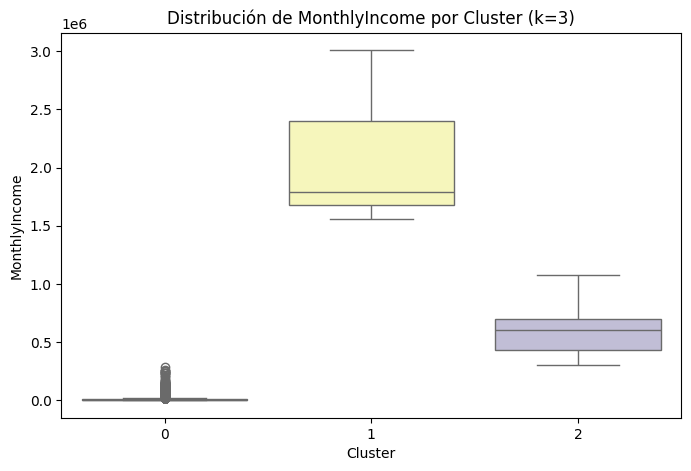

C:\Users\LagAl\AppData\Local\Temp\ipykernel_40252\2585081530.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df, palette='Set3')


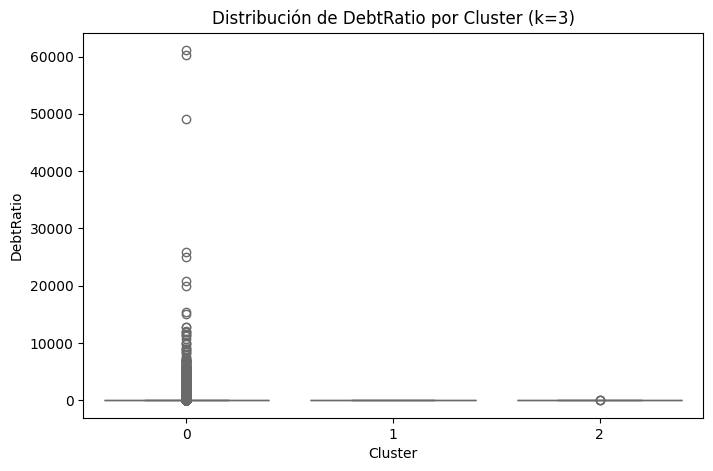

C:\Users\LagAl\AppData\Local\Temp\ipykernel_40252\2585081530.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df, palette='Set3')


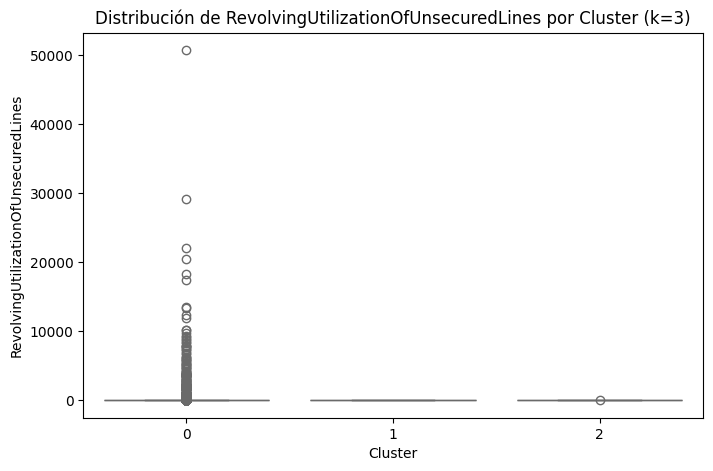

C:\Users\LagAl\AppData\Local\Temp\ipykernel_40252\2585081530.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df, palette='Set3')


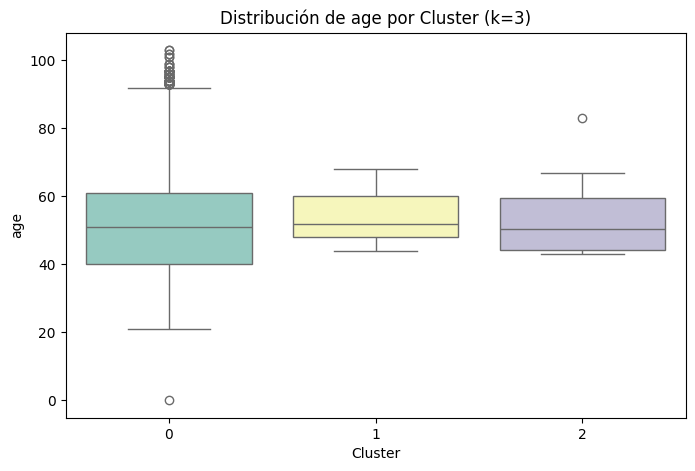

C:\Users\LagAl\AppData\Local\Temp\ipykernel_40252\2585081530.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df, palette='Set3')


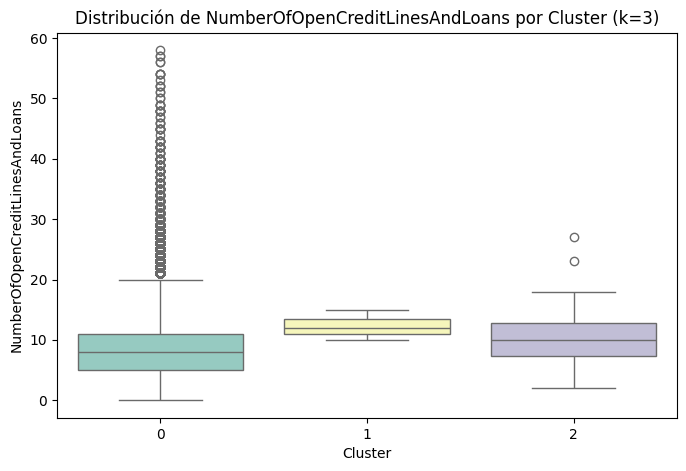

C:\Users\LagAl\AppData\Local\Temp\ipykernel_40252\2585081530.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df, palette='Set3')


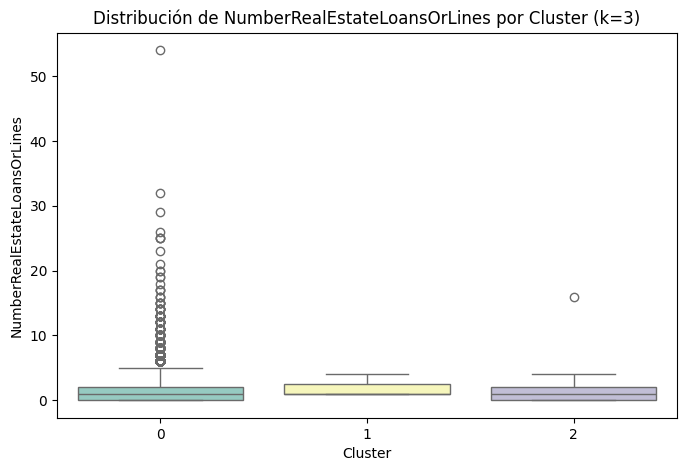

C:\Users\LagAl\AppData\Local\Temp\ipykernel_40252\2585081530.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df, palette='Set3')


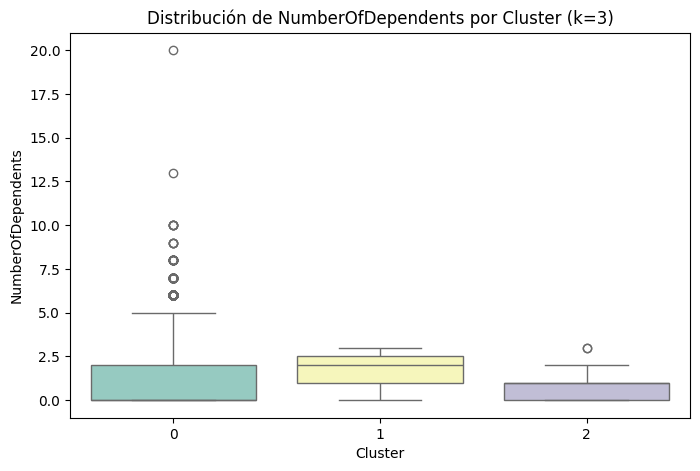

C:\Users\LagAl\AppData\Local\Temp\ipykernel_40252\2585081530.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df, palette='Set3')


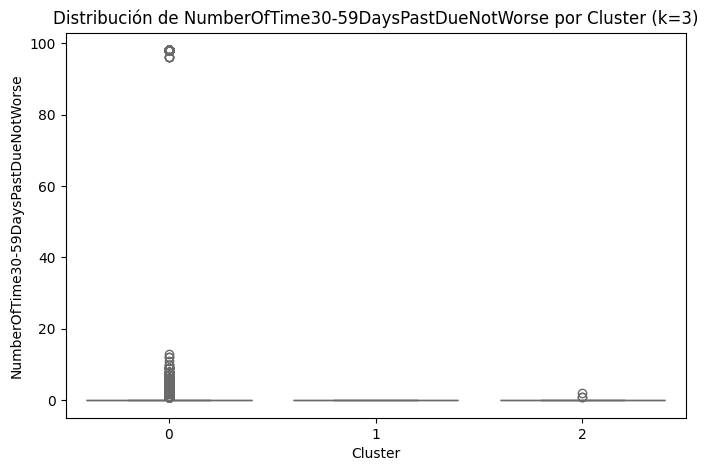

C:\Users\LagAl\AppData\Local\Temp\ipykernel_40252\2585081530.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df, palette='Set3')


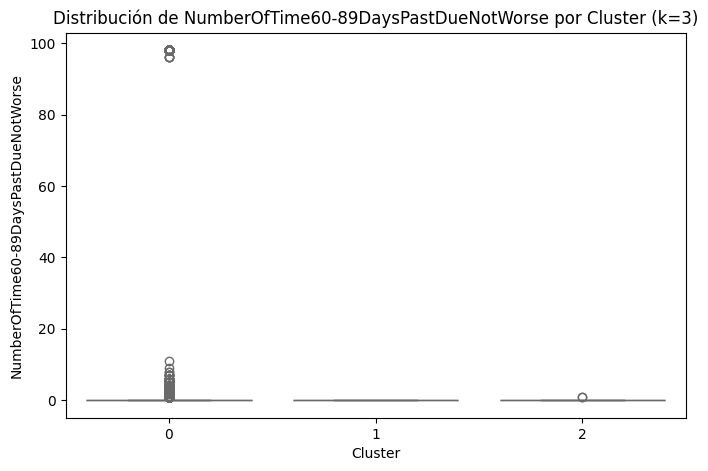

C:\Users\LagAl\AppData\Local\Temp\ipykernel_40252\2585081530.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df, palette='Set3')


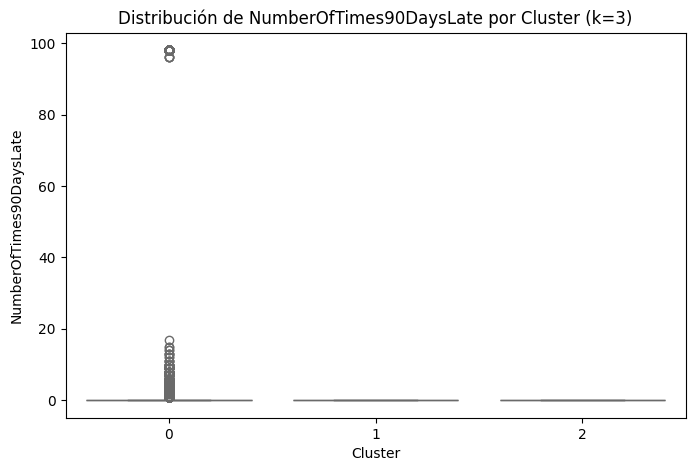

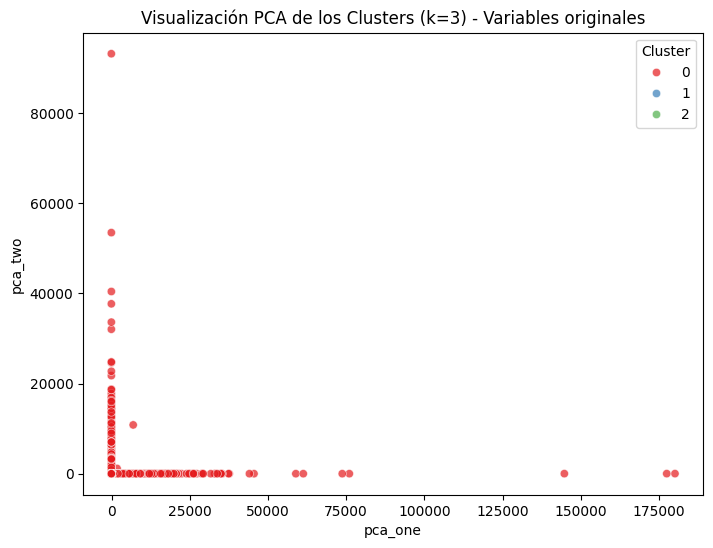

Archivo 'clientes_clusterizados_k6_sin_logs.csv' guardado con las variables originales.


In [ ]:
df = pd.read_csv('../data/data_raw/cs-training.csv')
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
df = df.dropna(subset=['MonthlyIncome'])
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)

offset = 1e-6
df['log_MonthlyIncome'] = np.log(df['MonthlyIncome'] + offset)
df['log_DebtRatio'] = np.log(df['DebtRatio'] + offset)
df['log_RevolvingUtilization'] = np.log(df['RevolvingUtilizationOfUnsecuredLines'] + offset)
df['Total_Morosidad'] = (df['NumberOfTime30-59DaysPastDueNotWorse'] +
                         df['NumberOfTimes90DaysLate'] +
                         df['NumberOfTime60-89DaysPastDueNotWorse'])
df['Income_to_Debt'] = df['log_MonthlyIncome'] / (df['log_DebtRatio'] + offset)

features = [
    'MonthlyIncome',
    'DebtRatio',
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines',
    'NumberOfDependents',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
]

X = df[features].copy()


scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

k = 3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

df['Cluster'] = kmeans.fit_predict(X)

print("Resumen estadístico por cluster (media):\n")
cluster_summary_mean = df.groupby('Cluster')[features].mean()
print(cluster_summary_mean)

print("\nResumen estadístico por cluster (mediana):\n")
cluster_summary_median = df.groupby('Cluster')[features].median()
print(cluster_summary_median)

for col in features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='Cluster', y=col, data=df, palette='Set3')
    plt.title(f"Distribución de {col} por Cluster (k={k})")
    plt.show()

from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_scaled)
df['pca_one'] = pca_result[:, 0]
df['pca_two'] = pca_result[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='pca_one', y='pca_two', hue='Cluster', palette='Set1', alpha=0.7)
plt.title(f"Visualización PCA de los Clusters (k={k}) - Variables originales")
plt.show()

cluster_labels = {
    0: "Cluster 0",
    1: "Cluster 1",
    2: "Cluster 2",
}
df['Cluster_Interpretado'] = df['Cluster'].map(cluster_labels)


df.to_csv('clientes_clusterizados_k6_sin_logs.csv', index=False)
print("Archivo 'clientes_clusterizados_k6_sin_logs.csv' guardado con las variables originales.")


Análisis de los Clusters
a) Observaciones Generales
Cluster con ingresos altísimos vs. ingresos muy bajos

Algunos grupos (por ejemplo, cluster 1, 2 y 4) muestran ingresos extremadamente altos (superiores a 600k, hasta 3 millones de media).

Otros (cluster 3) tienen ingresos mensuales muy bajos (~4,500), lo que contrasta enormemente con los primeros.

Relación Deuda/Ingreso (DebtRatio)

Hay casos donde el DebtRatio es muy bajo (~0.001–0.004), indicando que los ingresos son desproporcionadamente altos frente a la deuda.

En el cluster 3, la media de DebtRatio es 34.21, lo que sugiere una situación potencialmente de alto endeudamiento (o ingresos muy bajos).

Utilización de Crédito (RevolvingUtilizationOfUnsecuredLines)

Varía desde valores casi nulos (0.007) hasta valores bastante altos (13.0 o 3.88), reflejando outliers que tienen un uso muy elevado de sus líneas de crédito.

Es importante contrastar la media con la mediana, ya que los outliers pueden inflar la media sin representar el grueso del grupo.

Mora (NumberOfTime30-59Days..., 60-89Days..., 90DaysLate)

Varios clusters presentan mediana 0 en todas las variables de mora, lo cual significa que la mayoría de integrantes no tuvo atrasos.

Sin embargo, las medias en cluster 3 (por ejemplo, 30-59DaysPastDueNotWorse = 0.42, 90DaysLate = 0.26) indican que en ese grupo hay un subconjunto que sí muestra morosidad significativa.

b) Interpretación Cluster a Cluster
Cluster 0

MonthlyIncome: Media ~12,764; Mediana ~11,052 → ingresos relativamente altos, pero no extremos comparados con otros clusters.

DebtRatio: Media ~0.29, Mediana ~0.26 → deuda moderada frente a ingresos.

RevolvingUtilization: Media ~13.02, Mediana ~0.14 → presencia de outliers muy grandes (la mayoría tiene un uso bajo o moderado, pero unos pocos disparan la media).

Mora: Leve (NumberOfTime30-59Days… ~0.25), pero la mediana en 0 sugiere que la mayoría no experimentó atrasos.

Interpretación: Grupo con ingresos decentes, bajo riesgo de morosidad general, pero con outliers que tienen un uso de crédito sumamente elevado. Podría considerarse un segmento estable, con necesidad de revisar a esos outliers en RevolvingUtilization.

Cluster 1

MonthlyIncome: ~1.68M (media y mediana).

DebtRatio: ~0.0034 → muy baja proporción de deuda.

RevolvingUtilization: ~0.08.

Sin morosidad (las variables de past due están en 0).

Número de créditos abiertos: 13.5 de media, real estate ~2.5.

Interpretación: Clientes extremadamente altos ingresos, muy baja deuda y sin moras; seguramente un segmento premium con amplio acceso a líneas de crédito y riesgo prácticamente nulo.

Cluster 2

MonthlyIncome: Media ~645k, Mediana ~639k → también muy altos ingresos.

DebtRatio: ~0.0049 → también baja deuda en proporción a ingreso.

RevolvingUtilization: ~0.225 → moderado.

Mora: Casi nula, excepto 30-59DaysPastDue ~0.33 de media (podría haber un pequeño grupo con mora).

Edad ~ 54.7.

Interpretación: Ingresos altos, deuda relativamente baja, poca morosidad. Muy parecido a cluster 1, pero con un poco más de variabilidad en la mora y un RevolvingUtilization algo mayor. Sería un grupo también de bajo riesgo y alta capacidad de pago.

Cluster 3

MonthlyIncome: ~4,518 (media y mediana de 4,500) → ingresos mucho menores respecto a 1 y 2.

DebtRatio: ~34.21 → extremadamente alto, sugiriendo que sus deudas superan con creces sus ingresos.

RevolvingUtilization: ~3.88 → también alto uso del crédito.

Mora: 30-59Days ~0.42, 90DaysLate ~0.26 → un subconjunto significativo con atrasos.

Interpretación: Perfil de alto riesgo: ingresos bajos, endeudamiento elevado, varios eventos de mora. Podría representar un segmento que requeriría seguimiento cauteloso o condiciones de crédito más restrictivas.

Cluster 4

MonthlyIncome: Media ~3.0M, Mediana también ~3.0M → el más alto de todos.

DebtRatio: ~0.00147 → extremadamente bajo, prácticamente no hay deuda frente a sus ingresos masivos.

RevolvingUtilization: ~0.007 → uso de crédito ínfimo.

NumberOfDependents: 3 en mediana, sugiere familias grandes.

Mora: nula.

Interpretación: Clientes ultra-premium con ingresos descomunales, deuda mínima y cero moras. Es el mejor perfil en términos de solvencia financiera y podría interesar al negocio para productos VIP, dado su altísimo poder adquisitivo.

Cluster 5

MonthlyIncome: ~82k (media 66k mediana) → ingreso alto, pero no cercano a los millones de 1, 2 o 4.

DebtRatio: ~0.088 → bajo-moderado.

RevolvingUtilization: ~0.29 → utilización razonable de sus líneas de crédito.

Mora: leve (NumberOfTime60-89DaysPastDue ~0.046, 90DaysLate ~0.093 de media).

Número de créditos abiertos: ~11.3.

Interpretación: Ingresos cómodos, endeudamiento bajo, un poco de mora pero no muy grave. Un segmento acomodado con cierto uso de crédito y algo de riesgo, mas no extremo.

c) Conclusiones de Negocio
Clusters 1, 2 y 4:

Ingresos altísimos y un DebtRatio bajísimo: segmento VIP de muy bajo riesgo.

Diferencias mínimas en la morosidad (cluster 2 tiene un poco más de mora que 1 y 4). Aun así, siguen siendo segmentos atractivos para ofertas de productos premium y líneas de crédito más amplias.

Cluster 0:

Ingresos relativamente buenos, pero con outliers que podrían usar mucho sus líneas.

En general, buena oportunidad de negocio con precaución respecto a aquellos con RevolvingUtilization inflado.

Cluster 5:

Ingresos medios/altos (~66k mediana), deudas manejables, algo de mora.

Segmento que podría beneficiarse de programas de refinanciamiento o convenios para reducir incidencias de atraso.

Cluster 3:

El de mayor riesgo: ingresos bajos (~4,500) y DebtRatio de 34.21, con uso elevado de líneas de crédito y moras relevantes.

De cara al negocio, implicaría un control estricto en la aprobación de nuevas líneas y un seguimiento cercano para evitar mayores impagos.

